# Pix2Pix 논문구현

## 특징 : UNet 구조를 활용하여 paired dataset한정하여 image to image translation을 보여준다


In [ ]:
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## 데이터셋 준비

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch

Cloning into 'pix2pix-pytorch'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 68 (delta 17), reused 14 (delta 14), pack-reused 45
Unpacking objects: 100% (68/68), done.


In [ ]:
!mkdir 'data'

In [ ]:
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data;

## Custom Dataset 정의

### b 이미지는 선만 있는 이미지, a 이미지는 이를 실사화한 이미지

In [ ]:
class FacadeDataset(Dataset):
  def __init__(self, path2img, direction = 'b2a', transform = False):
    super(FacadeDataset, self).__init__()
    self.direction = direction
    self.path2a = os.path.join(path2img, 'a')
    self.path2b = os.path.join(path2img, 'b')
    self.img_filenames = [x for x in os.listdir(self.path2a)]
    self.transform = transform

  def __getitem__(self, index):
    a = Image.open(os.path.join(self.path2a, self.img_filenames[index])).convert('RGB')
    b = Image.open(os.path.join(self.path2b, self.img_filenames[index])).convert('RGB')

    if self.transform:
      a = self.transform(a)
      b = self.transform(b)

    if self.direction == 'b2a':
      return b, a #만약 b가 선 이미지라면 b, a순으로 return해준다
    else:
      return a, b
    
  def __len__(self):
    return len(self.img_filenames)

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.Resize((256, 256))
])

In [ ]:
path2img = '/content/data/facades/train'
train_dataset = FacadeDataset(path2img, transform = trans)

## 이미지 시각화

(-0.5, 255.5, 255.5, -0.5)

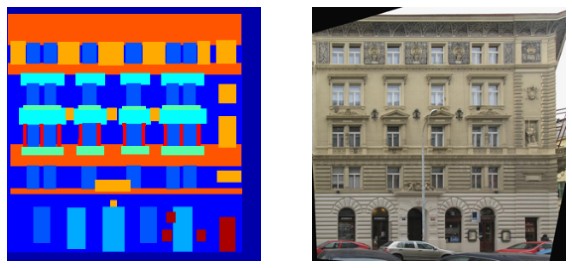

In [ ]:
a, b = train_dataset[4]
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(a *0.5  + 0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5 *b + 0.5))
plt.axis('off')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

## 모델 구축하기
### UNet구조를 사용한다

In [ ]:
class UNetDown(nn.Module): #UNet class 정의하기
  def __init__(self, in_channels, out_channels, normalize = True, dropout = 0.0):
    super(UNetDown, self).__init__()
    layers = [nn.Conv2d(in_channels, out_channels,4, stride = 2, padding = 1, bias = False)]

    if normalize:
      layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2))

    if dropout:
      layers.append(nn.Dropout(dropout))
    self.down = nn.Sequential(*layers)

  def forward(self, x):
    x = self.down(x)
    return x

In [ ]:
x = torch.rand(16, 3, 256, 256, device = device)
model = UNetDown(3, 64).to(device)
down_out = model(x)
print(down_out.shape) # B, C, H, W

torch.Size([16, 64, 128, 128])


In [ ]:
class UNetUp(nn.Module):
  def __init__(self, in_channels, out_channels, dropout = 0.0):
    super(UNetUp, self).__init__()
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False)
        ,nn.InstanceNorm2d(out_channels)
        ,nn.LeakyReLU()
    ]
    if dropout:
      layers.append(nn.Dropout(dropout))
    self.up = nn.Sequential(*layers)
  def forward(self, x, skip):
    x = self.up(x)
    x = torch.cat((x, skip), 1)
    return x

In [ ]:
x = torch.rand(16, 128, 64, 64, device = device)
model = UNetUp(128, 64).to(device)
out = model(x, down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


## 생성자 정의

In [ ]:
class GeneratorUNet(nn.Module):
  def __init__(self, in_channels = 3, out_channels = 3):
    super(GeneratorUNet, self).__init__()
    self.down1 = UNetDown(in_channels, 64, normalize = False)
    self.down2 = UNetDown(64, 128)
    self.down3 = UNetDown(128, 256)
    self.down4 = UNetDown(256, 512, dropout = 0.5)
    self.down5 = UNetDown(512, 512, dropout = 0.5)
    self.down6 = UNetDown(512, 512, dropout = 0.5)
    self.down7 = UNetDown(512, 512, dropout = 0.5)
    self.down8 = UNetDown(512, 512, normalize = False, dropout = 0.5)

    self.up1 = UNetUp(512, 512, dropout = 0.5)
    self.up2 = UNetUp(1024, 512, dropout = 0.5)
    self.up3 = UNetUp(1024, 512, dropout = 0.5)
    self.up4 = UNetUp(1024, 512, dropout = 0.5)
    self.up5 = UNetUp(1024, 256)
    self.up6 = UNetUp(512, 128)
    self.up7 = UNetUp(256, 64)
    self.up8 = nn.Sequential(
        nn.ConvTranspose2d(128, 3, 4, stride = 2, padding = 1),
        nn.Tanh()
    )

  def forward(self, x):
    d1 = self.down1(x)
    d2 = self.down2(d1)
    d3 = self.down3(d2)
    d4 = self.down4(d3)
    d5 = self.down5(d4)
    d6 = self.down6(d5)
    d7 = self.down7(d6)
    d8 = self.down8(d7)

    u1 = self.up1(d8, d7)
    u2 = self.up2(u1, d6)
    u3 = self.up3(u2, d5)
    u4 = self.up4(u3, d4)
    u5 = self.up5(u4, d3)
    u6 = self.up6(u5, d2)
    u7 = self.up7(u6, d1)
    u8 = self.up8(u7)

    return u8

In [ ]:
x = torch.rand(16, 3, 256, 256, device = device)
model = GeneratorUNet().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


In [ ]:
class Dis_block(nn.Module):
  def __init__(self, in_channels, out_channels, normalize = True):
    super(Dis_block, self).__init__()
    layers = [nn.Conv2d(in_channels, out_channels, 3, stride = 2, padding = 1)]
    if normalize:
      layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    x = self.block(x)
    return x

In [ ]:
x = torch.rand(16, 64, 128, 128, device = device)
model = Dis_block(64, 128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


## 판별자 정의

##patchGAN 을 사용

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3):
    super(Discriminator, self).__init__()
    self.stage_1 = Dis_block(in_channels * 2, 64, normalize = False)
    self.stage_2 = Dis_block(64, 128)
    self.stage_3 = Dis_block(128, 256)
    self.stage_4 = Dis_block(256, 512)

    self.path = nn.Conv2d(512, 1, 3, padding = 1) # 16 * 16 의 패치 생성

  def forward(self, a, b):
    x = torch.cat((a, b), 1)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.stage_4(x)
    x = self.path(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
x = torch.rand(16, 3, 256, 256, device =device)
model = Discriminator().to(device)
out = model(x, x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [ ]:
model_gen = GeneratorUNet().to(device) # 모델생성
model_dis = Discriminator().to(device)

# 모델 학습

In [ ]:
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

lambda_pixel = 100 #loss_func_pix 가중치

patch = (1, 256 // 2 ** 4, 256 // 2 ** 4) #(1, 16, 16)

optim_dis = optim.Adam(model_dis.parameters(), lr = 2e-4, betas = (0.5, 0.999))
optim_gen = optim.Adam(model_gen.parameters(), lr = 2e-4, betas = (0.5, 0.999))

In [ ]:
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 50

loss_hist = {'gen' : [], 'dis' : []}

for epoch in range(num_epochs):
  for a, b in train_loader:

    batch_size = a.size(0)

    real_a = a.to(device)
    real_b = b.to(device)

    real_label = torch.ones(batch_size, *patch, requires_grad = False).to(device)
    fake_label = torch.zeros(batch_size, *patch, requires_grad = False).to(device)

    model_gen.zero_grad() #생성자 훈련 위한 가중치 초기화

    fake_b = model_gen(real_a) #선 이미지로 가짜 이미지 생성
    out_dis = model_dis(fake_b, real_b) #가짜 이미지인지 진짜 이미지인지 판별

    gen_loss = loss_func_gan(out_dis, real_label) #최대한 1에 가깝게 만들 수 있도록 generator 훈련
    pixel_loss = loss_func_pix(fake_b, real_b) #진짜 이미지와 가짜이미지간의 L1 loss계산

    g_loss = gen_loss + lambda_pixel * pixel_loss
    g_loss.backward()
    optim_gen.step()

    model_dis.zero_grad() #구별자 훈련 위한 가중치 초기화
    out_dis = model_dis(real_b, real_a) #진짜 이미지 인식
    real_loss = loss_func_gan(out_dis, real_label) #최대한 1에 가깝게 훈련
    
    out_dis = model_dis(fake_b.detach(), real_a) #가짜 이미지 인식, 구별자 훈련 중이므로 생성자 훈련 x
    fake_loss = loss_func_gan(out_dis, fake_label) #0에 가깝게 훈련

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optim_dis.step()

    loss_hist['gen'].append(g_loss.item())
    loss_hist['dis'].append(d_loss.item())

    batch_count += 1
    if batch_count % 100 == 0:
      print(f'Epoch : {epoch}, G_loss : {g_loss.item():.3f}, D_loss : {d_loss.item():.3f}')

Epoch : 7, G_loss : 36.269, D_loss : 0.096
Epoch : 15, G_loss : 31.533, D_loss : 0.210
Epoch : 23, G_loss : 30.955, D_loss : 0.017
Epoch : 30, G_loss : 26.156, D_loss : 0.018
Epoch : 38, G_loss : 25.972, D_loss : 0.010
Epoch : 46, G_loss : 23.648, D_loss : 0.317


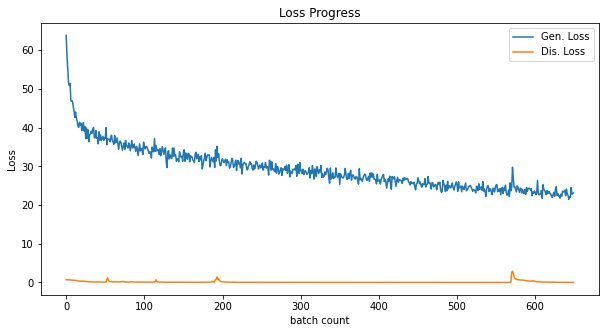

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [ ]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_loader:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

##  이미지 생성 결과
## 50회의 반복치고는 꽤 나쁘지 않은 결과 생성
## 선 이미지로 나름 비슷한 이미지 만들어 내는 것이 신가하다

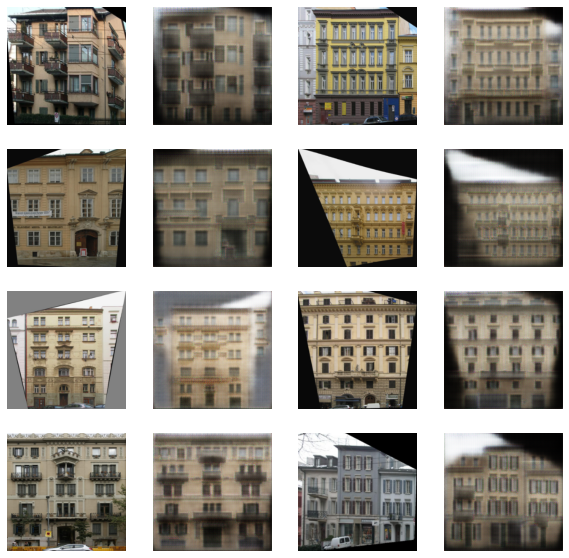

In [ ]:
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_imagce(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')